# **Descarga del dataset**



In [ ]:
import kagglehub

# Download latest version
path4 = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path4)

Path to dataset files: /kaggle/input/creditcardfraud


# **Parte 1 - Reducción de dimensionalidad (solo pre-procesamiento)**

El objetivo es realizar una reducción de dimensionalidad a través de t-SNE y UMAP a 2 dimensiones. Además de realizar un gráfico coloreando fraude/no fraude.

A diferencia de los modelos vistos en los ejercicios anteriores t-SNE y UMAP son modelos no lineals, es decir, tienen como objetivo preservar las relaciones de vecindad. Para esto utilizan funciones y algoritmos no lineales.

El dataset a utilizar es Credit Card Fraud Detection el cual contiene las transacciones con tarjeta de crédito realizadas por clientes europeos durante dos días en el mes de septiembre de 2013. El dataset posee 284.807 filas de transacciones y 31 columnas de las cuales se tienen componentes principales, tiempo (segundos transcurridos desde la primera transaccion), monto de la transaccion y una variable objetivo que separa casos legítimos y casos fraude.

Partiremos cargando las librerías a utilizar en las reducciones de dimensionalidad y para realizar el gráfico requerido.

In [ ]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Carguemos el dataset y visualicemos las primeras 5 filas para ver su estructura.

In [ ]:
df4 = pd.read_csv(path4 + '/creditcard.csv')
df4.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Ahora, veamos si el dataset posee datos nulos para ser arreglados.

In [ ]:
df4.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Notemos que el dataset posee 3 variables que no aportan información para la reducción de dimensionalidad, estas son Time, Amount y Class. Procederemos a eliminarlas y Class la guardaremos en la variable objetivo para luego usarla al momento de visualizar.

In [ ]:
X = df4.drop(columns=['Time', 'Amount', 'Class'])
y = df4['Class']

Veamos entre que valores se mueven las variables del dataset para ver si es necesario estandarizarlos.

In [ ]:
print(X.describe().loc[['min','max']])
print(y.describe().loc[['min','max']])

           V1         V2         V3         V4          V5         V6  \
min -56.40751 -72.715728 -48.325589  -5.683171 -113.743307 -26.160506   
max   2.45493  22.057729   9.382558  16.875344   34.801666  73.301626   

             V7         V8         V9        V10  ...       V19        V20  \
min  -43.557242 -73.216718 -13.434066 -24.588262  ... -7.213527 -54.497720   
max  120.589494  20.007208  15.594995  23.745136  ...  5.591971  39.420904   

           V21        V22        V23       V24        V25       V26  \
min -34.830382 -10.933144 -44.807735 -2.836627 -10.295397 -2.604551   
max  27.202839  10.503090  22.528412  4.584549   7.519589  3.517346   

           V27        V28  
min -22.565679 -15.430084  
max  31.612198  33.847808  

[2 rows x 28 columns]
min    0.0
max    1.0
Name: Class, dtype: float64


Notemos que antes de realizar las reducciones de dimensionalidad necesitamos estandarizar el dataset, debido a que tanto t-SNE como UMAP son sensibles a la escalabilidad de la dimensión.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Partiremos usando t-SNE. Este es un modelo no lineal, por lo que se ocupa una metodología de entrenamiento para preservar la cercanía y lejanía de los puntos al reducir la dimensionalidad. Se utiliza porque es muy rápido y eficiente para poder visualizar.

In [ ]:
# tsne = TSNE(n_components=2, # Numero de componentes
#            perplexity=48, # Vecinos cercanos
#            learning_rate=200, # Taza de aprendizaje
#            random_state=42) # Semilla

# X_tsne = tsne.fit_transform(X_scaled)

Notemos que al ejecutar el modelo se demora un tiempo considerable en terminar de compilar. Por esto, tomaremos un porcentaje de los datos para poder realizar la visualización (aproximadamente 10.000 entradas).

In [ ]:
X_red,_, y_red,_ = train_test_split(X_scaled, y, test_size=0.965,random_state = 42, stratify=y)

Ahora, procederemos a realizar la reducción de dimensionalidad por t-SNE.

In [ ]:
tsne = TSNE(n_components=2, # Numero de componentes
            perplexity=48, # Vecinos cercanos
            learning_rate=200, # Taza de aprendizaje
            random_state=42) # Semilla

X_tsne = tsne.fit_transform(X_red)

Por último, procederemos con la visualización de los datos luego de la reducción de dimensionalidad.

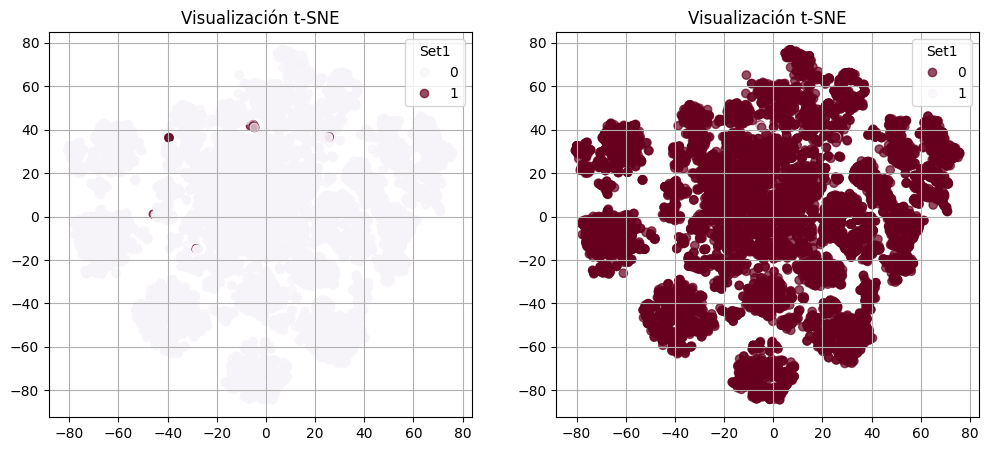

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

scatter_ax0 = axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_red, cmap='PuRd', alpha=0.7)
axs[0].legend(*scatter_ax0.legend_elements(), title="Set1")
axs[0].set_title('Visualización t-SNE')
axs[0].grid(True)

scatter_ax1 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_red, cmap='PuRd_r', alpha=0.7)
axs[1].legend(*scatter_ax1.legend_elements(), title="Set1")
axs[1].set_title('Visualización t-SNE')
axs[1].grid(True)

plt.show()

Notemos que la información entregada del dataset nos indica que los casos de fraude son un 0.172% de todas las transacciones, lo cual se evidencia en los gráficos de la reducción de dimensionalidad.

Ahora, se realizará la reducción de dimensionalidad y gráfico a través del método UMAP.

UMAP es una proyección no lineal que consiste en modelar las relaciones topológicas entre puntos usando grafos, con el objetivo de mantener la estructura global y local.

Usaremos el mismo número de datos que en t-SNE para poder comparar sus reducciones y realizar una conclusión (10.000 muestras aprox.).

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_red)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Luego, procedemos a visualizar la reducción.

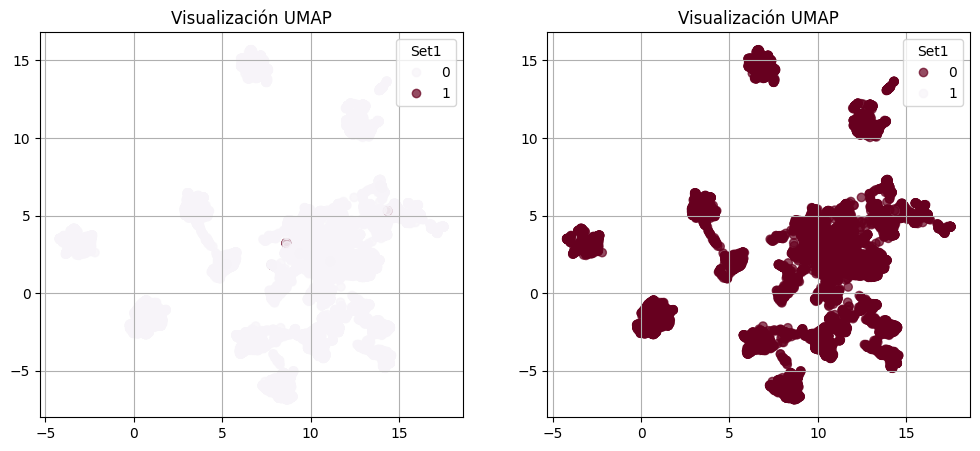

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

scatter_ax0 = axs[0].scatter(X_umap[:, 0], X_umap[:, 1], c=y_red, cmap='PuRd', alpha=0.7)
axs[0].legend(*scatter_ax0.legend_elements(), title="Set1")
axs[0].set_title('Visualización UMAP')
axs[0].grid(True)

scatter_ax1 = axs[1].scatter(X_umap[:, 0], X_umap[:, 1], c=y_red, cmap='PuRd_r', alpha=0.7)
axs[1].legend(*scatter_ax1.legend_elements(), title="Set1")
axs[1].set_title('Visualización UMAP')
axs[1].grid(True)

plt.show()

Al igual que con t-SNE, los gráficos de la reducción por UMAP evidencian que los casos de fraude solo representan el 0.172% de los datos totales.


Por último, realicemos una comparación de ambos métodos:

- t-SNE se enfoca en preservar las distancias locales, lo que es útil para visualizar agrupaciones. Sin embargo, no siempre preserva la estructura global y puede ser más lento con grandes datasets.

- UMAP se enfoca en preservar tanto la estructura local como la global, lo que puede representar una ventaja. En este caso vimos que UMAP fue considerablemente más rápido que t-SNE.

- En las gráficas se observa una diferencia entre las agrupaciones, esto se debe a que t-SNE no garantiza que la distancia entre los clústeres sea representativa de su distancia en el espacio original, como si lo hace UMAP.


La elección entre uno u otro dependerá principalmente del objetivo a cumplir al momento de realizar la reducción. También dependerá del tamaño del dataset y del tiempo requerido para realizar la tarea.

Por lo tanto, para enfoques en visualización de agrupaciones locales y datasets pequeños es preferible t-SNE; por otro lado para enfoques de búsqueda de una mejor representación de la estructura global de los datos y datasets grandes es preferible UMAP.

# **Parte 2 - Modelado sobre datos en bruto y reducidos**

El objetivo es aplicar los modelos supervisados Logistic Regresion y Random Forest con y sin t-SNE y UMAP para comparar sus rendimientos y utilidades.

Partamos cargando las librerías necesarias para la realización de los modelos y el dataset respectivo.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline        import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.combine         import SMOTETomek

In [ ]:
df4 = pd.read_csv(path4 + '/creditcard.csv')

Separemos las característias que definen el fraude (o no) y la variable objetivo en X e y. Tomaremos una muestra de 10 mil casos para evitar tiempos de ejecución elevados.

In [ ]:
X = df4.drop(columns=['Class','Time'])
y = df4['Class']
X_red,_, y_red,_ = train_test_split(X, y, test_size=0.9,random_state = 42, stratify=y)
X_tr, X_te, y_tr, y_te = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

Visualicemos las clases por si se hace necesario un balanceo de las mismas como en el ejercicio anterior.

<ipython-input-9-2135267221>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


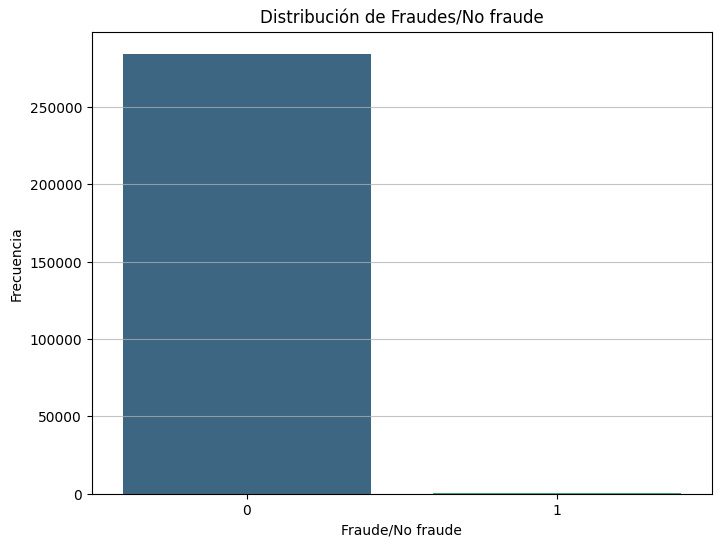

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y, palette='viridis')
plt.title('Distribución de Fraudes/No fraude')
plt.xlabel('Fraude/No fraude')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

Como podemos notar es muy evidente el desbalanceo de clases y como los fraudes son muy pocos en frecuencia haremos un balanceo de clases creando datos sintéticos dentro de los modelos.

## **Modelo 1: Logistic Regression**

Se asumirá una penalización de tipo Lasso en el modelo, utilizando un parámetro de regularización igual a 0.1. Para garantizar la convergencia del algoritmo, se establecerá un máximo de 5000 iteraciones en el caso de los datos sin reducción y de 1000 iteraciones para los datos reducidos.

Dado el desbalance de clases presente en el conjunto de datos, se aplicará previamente la técnica SMOTE para sobremuestrear las clases menos representadas y mejorar el equilibrio entre categorías.

Sin reducciones t-SNE y UMAP:

In [ ]:
smote = SMOTETomek(random_state=42)

In [ ]:
pipe_log_reg_bal = ImbPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('logi_reg_smote', LogisticRegression(
        random_state=42,
        max_iter=5000,
        solver='saga',
        penalty='l1',
        C=0.1,
        class_weight='balanced'
    ))
])

Procedemos con el entrenamiento.

In [ ]:
pipe_log_reg_bal.fit(X_tr, y_tr)

Pipeline(steps=[('smote', SMOTETomek(random_state=42)),
                ('scaler', StandardScaler()),
                ('logi_reg_smote',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=5000, penalty='l1',
                                    random_state=42, solver='saga'))])

Seguimos con la predicción y evaluación de esta.

In [ ]:
y_pred_log_reg_bal = pipe_log_reg_bal.predict(X_te)

print(confusion_matrix(y_te, y_pred_log_reg_bal))
print(classification_report(y_te, y_pred_log_reg_bal))

[[5619   71]
 [   1    5]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5690
           1       0.07      0.83      0.12         6

    accuracy                           0.99      5696
   macro avg       0.53      0.91      0.56      5696
weighted avg       1.00      0.99      0.99      5696



Con reducción UMAP:

In [ ]:
pipe_log_reg_bal_umap = ImbPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_components=2, random_state=42)),
    ('logreg', LogisticRegression(
        random_state=42,
        max_iter=1000,
        solver='liblinear',
        penalty='l1',
        C=0.1
    ))
])

Entrenamiento

In [ ]:
pipe_log_reg_bal_umap.fit(X_tr, y_tr)

Pipeline(steps=[('smote', SMOTETomek(random_state=42)),
                ('scaler', StandardScaler()),
                ('umap',
                 UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('logreg',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

Prediccion

In [ ]:
y_pred_log_reg_bal_umap = pipe_log_reg_bal_umap.predict(X_te)

print(confusion_matrix(y_te, y_pred_log_reg_bal_umap))
print(classification_report(y_te, y_pred_log_reg_bal_umap))

[[5315  375]
 [   2    4]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      5690
           1       0.01      0.67      0.02         6

    accuracy                           0.93      5696
   macro avg       0.51      0.80      0.49      5696
weighted avg       1.00      0.93      0.96      5696



## **Modelo 2: Random Forest**

Dentro del pipeline del modelo Random Forest se aplicará la técnica SMOTE para balancear las clases, generando datos para mitigar el desbalance en las clases. A continuación, se realizará un escalado estándar de las variables. Finalmente, se entrenará un Random Forest Classifier con 100 árboles, una profundidad máxima de 3 y ponderación automática de clases (class_weight='balanced'), con el fin de mejorar la sensibilidad del modelo frente a fraudes y priorizar la detección en contextos con alta desproporción entre clases.

Sin reducciones t-SNE y UMAP

In [ ]:
pipe_rf_bal = ImbPipeline([
    ('smote', smote),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=3
    ))
])

Entrenamiento

In [ ]:
pipe_rf_bal.fit(X_tr, y_tr)

Pipeline(steps=[('smote',
                 SMOTETomek(random_state=42, smote=SMOTE(k_neighbors=3))),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

Visualicemos hasta la tercera profundidad el árbol de Regresión

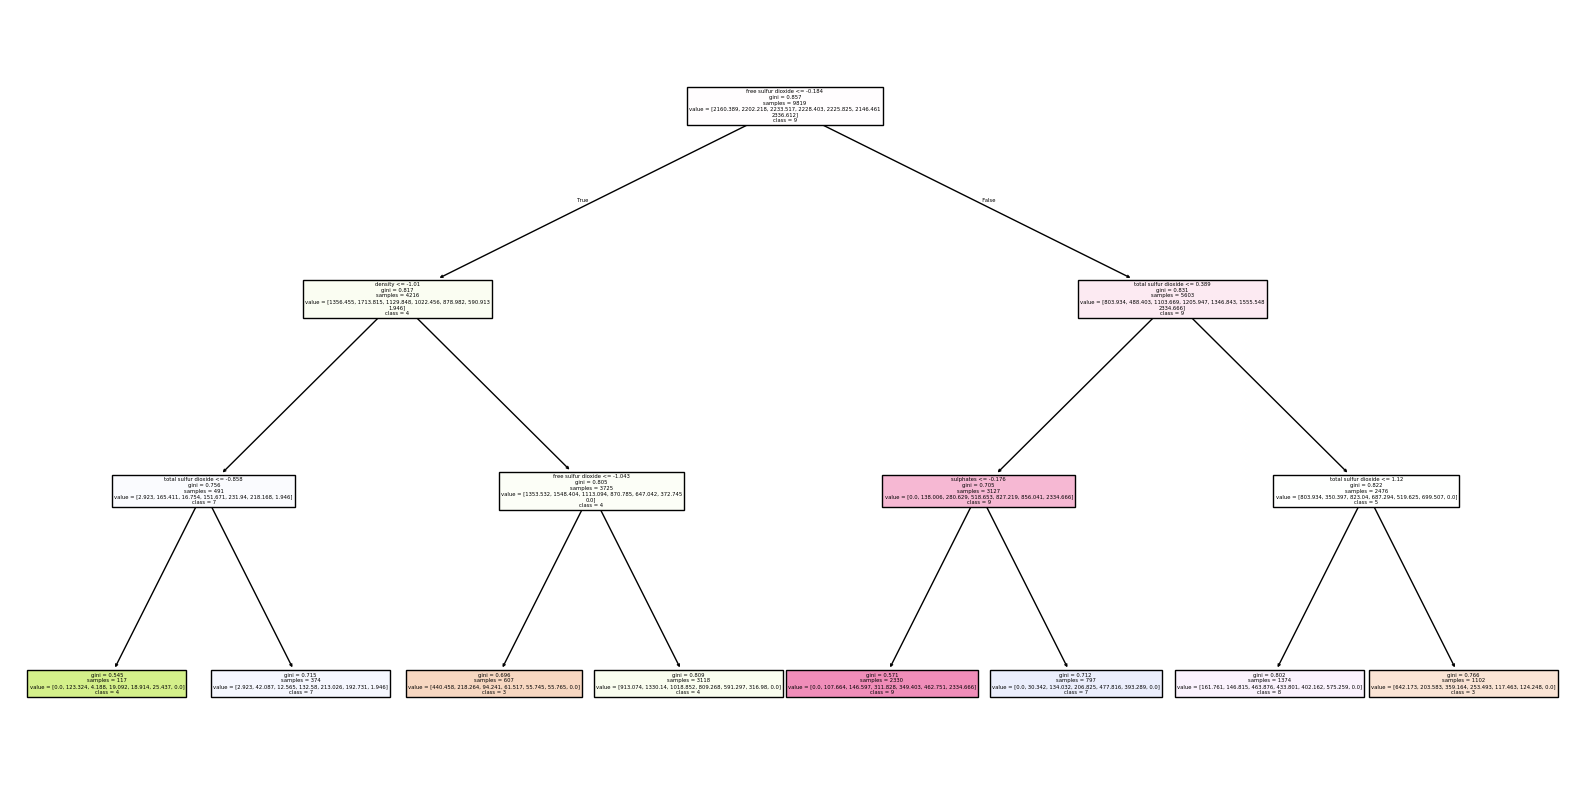

In [ ]:
rf_model_bal = pipe_rf_bal.named_steps["rf"]

# Extraemos el primer árbol del Random Forest
first_tree_bal = rf_model_bal.estimators_[0]

# Obtener las clases únicas del modelo entrenado
model_classes_bal = rf_model_bal.classes_

class_names_list_bal = [str(cls) for cls in model_classes_bal]

# Graficamos
plt.figure(figsize=(20, 10))
plot_tree(first_tree_bal, filled=True, feature_names=X_tr.columns, class_names=class_names_list_bal, max_depth=3)
plt.show()

Predicción

In [ ]:
y_pred_rf_bal = pipe_rf_bal.predict(X_te)

print(confusion_matrix(y_te, y_pred_rf_bal))
print(classification_report(y_te, y_pred_rf_bal))

[[  4   0   0   0   0   0   0]
 [ 11  18   9   4   3   3   0]
 [ 57  82 209  38  16  23   5]
 [ 31  50 175  70  65 133  16]
 [  4   6  20  26  51 113   8]
 [  0   0   2   1  13  21   5]
 [  0   0   0   0   0   1   0]]
              precision    recall  f1-score   support

           3       0.04      1.00      0.07         4
           4       0.12      0.38      0.18        48
           5       0.50      0.49      0.49       430
           6       0.50      0.13      0.21       540
           7       0.34      0.22      0.27       228
           8       0.07      0.50      0.12        42
           9       0.00      0.00      0.00         1

    accuracy                           0.29      1293
   macro avg       0.23      0.39      0.19      1293
weighted avg       0.45      0.29      0.31      1293



Con reducción UMAP:

In [ ]:
pipe_rf_bal_umap = Pipeline([
    ('scaler', StandardScaler()),
    ('umap', umap.UMAP(n_components=2, random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight='balanced',
        max_depth=3
    ))
])

Entrenamiento

In [ ]:
pipe_rf_bal_umap.fit(X_tr, y_tr)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('umap',
                 UMAP(n_jobs=1, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=3,
                                        random_state=42))])

Predicción

In [ ]:
y_pred_rf_bal_umap = pipe_rf_bal_umap.predict(X_te)

print(confusion_matrix(y_te, y_pred_rf_bal_umap))
print(classification_report(y_te, y_pred_rf_bal_umap))

[[5688    2]
 [   2    4]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5690
           1       0.67      0.67      0.67         6

    accuracy                           1.00      5696
   macro avg       0.83      0.83      0.83      5696
weighted avg       1.00      1.00      1.00      5696



## Tabla Comparativa de Modelos

| Modelo              | Reducción | Precision | Recall | F1-score | Accuracy | Tiempo de Ejecución |
|---------------------|-----------|-----------------------|--------------------|----------------------|----------|----------|
| Logistic Regression | Sin UMAP  | 0.53                  | 0.91               | 0.56                 | 0.99     | 1min 59s  |
| Logistic Regression | Con UMAP  | 0.51                  | 0.80               | 0.49                 | 0.93     |9min 12s|
| Random Forest       | Sin UMAP  | 0.67                  | 0.92               | 0.74                 | 1.00     | 30s |
| Random Forest       | Con UMAP  | 0.83                  | 0.83               | 0.83                 | 1.00     |  43s

Notemos que para Random Forest,pese a que sin UMAP tiene un rendimiento bastante alto. Con UMAP, el recall disminuye, pero la precision y F1-score se mantienen altas, además que Accuracy sigue siendo 1.

En cuanto a Logistic Regression, aunque el Recall es alto en ambos casos, la presición es muy baja, esto significa que si bien identifica correctamente una gran parte de los fraudes reales, tambien clasifica de forma incorrecta muchas de las transacciones.

Además que para este dataset altamente desbalanceado,pues la clase de fraude es minoria. Se tiene que la reducción de dimensionalidad no proporciona una mejora significativa al momento de clasificar.

Es importante considerar que UMAP, fue utilizado con una reducción a 2 componentes, para poder visualizar en la primera parte, y con ello se tiene una perdida significativa de información.

Por último el mejor modelo basado en las métricas es Random Forest sin reducción UMAP.